In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from collections import defaultdict

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/global-wheat-detection-public'

#WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn_best.pth'

DIR_INPUT = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
%load_ext autotime

In [2]:
DIR_TEST
#/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test

'/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test'

time: 1.94 ms


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

time: 569 µs


In [4]:
DIR_INPUT

'/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'

time: 1.9 ms


In [5]:
test_df = pd.read_csv('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test.csv')
test_df.shape

(214, 5)

time: 24.9 ms


In [6]:
test_df

,image_id,width,height,bbox,source
0,f5a1f0358.jpg,1024,1024,"[121.0, 204.0, 108.0, 147.0]",usack_1
1,f5a1f0358.jpg,1024,1024,"[216.0, 288.0, 127.0, 130.0]",usack_1
2,f5a1f0358.jpg,1024,1024,"[49.0, 449.0, 184.0, 154.0]",usack_1
3,f5a1f0358.jpg,1024,1024,"[280.0, 445.0, 176.0, 111.0]",usack_1
4,f5a1f0358.jpg,1024,1024,"[455.0, 292.0, 92.0, 216.0]",usack_1
...,...,...,...,...,...
209,2fd875eaa.jpg,1024,1024,"[917.0, 644.0, 98.0, 78.0]",usack_1
210,2fd875eaa.jpg,1024,1024,"[867.0, 56.0, 129.0, 104.0]",usack_1
211,2fd875eaa.jpg,1024,1024,"[698.0, 114.0, 119.0, 121.0]",usack_1
212,2fd875eaa.jpg,1024,1024,"[894.0, 852.0, 72.0, 149.0]",usack_1


time: 12.9 ms


In [7]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        #print('records->',f'{self.image_dir}/{image_id}')
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 2.43 ms


In [8]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

time: 441 µs


In [9]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

time: 465 ms


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
# Load the trained weights
model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
model.eval()#x = model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

time: 1.43 s


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

time: 1.85 ms


In [12]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

time: 1.26 ms


In [13]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        #true_boxes = np.array([[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in true_boxes])
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        #print('boxesA->',boxes)
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print('image->',image.shape,type(image))
            #print('target-boxes->',target['boxes'])
            
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 3.11 ms


In [14]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    #print('images->',images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


time: 846 ms


In [15]:
#test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
#test_df.head()

time: 277 µs


In [16]:
#sample = images[1].permute(1,2,0).cpu().numpy()
#boxes = outputs[1]['boxes'].data.cpu().numpy()
#scores = outputs[1]['scores'].data.cpu().numpy()

#boxes = boxes[scores >= 0.5].astype(np.int32)

time: 328 µs


In [17]:
def show_img(sample,boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        #rint(box)
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(sample)

time: 1.47 ms


In [18]:
#show_img(sample,boxes)

time: 278 µs


# Real 

In [19]:
images, image_ids = next(iter(test_data_loader))

time: 240 ms


In [20]:
#pred_boxes=outputs[1]['boxes'].data.cpu().numpy() # 2fd875eaa.jpg
#sample = images[1].permute(1,2,0).cpu().numpy()
#scores = outputs[1]['scores'].data.cpu().numpy()
#pred_boxes

time: 317 µs


In [21]:
import ast
test_df['bbox'] = test_df['bbox'].apply(lambda x: ast.literal_eval(x))

time: 5.35 ms


In [22]:
true_boxes=np.array(test_df[test_df.image_id=='2fd875eaa.jpg']['bbox'].apply(lambda x : [ i / 1024 for i in x]).tolist())

time: 2.59 ms


In [23]:
#print(len(scores),len(true_boxes),len(pred_boxes))

time: 456 µs


In [24]:
import torchvision.transforms.functional as FT
from torchvision.ops.boxes import box_iou

#pred_boxes = FT.to_tensor(pred_boxes)
#true_boxes =  FT.to_tensor(true_boxes)

time: 716 µs


# MAP

In [25]:
def make_input_image(img_path,input_size):
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    new_image = image_arr

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return new_image_model


def calculate_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: list, threshold=0.5) -> float:
    """Calculates precision for GT - prediction pairs at one threshold."""
    #print('boxes_true->',boxes_true)
    confidences = np.array(confidences)

    # edge case for no ground truth boxes
    #print('calculate_precision_boxes_true->',boxes_true)
    if boxes_true.size(1) == 0:
    
        return 0.

    #print('boxes_pred',boxes_pred.cpu())
    #print('boxes_true',boxes_true.cpu())
    #boxes_pred.cpu()
    #boxes_true.cpu()
    #print('boxes_pred->',boxes_pred)
    #print('boxes_true->?',boxes_true)
    iou = box_iou(boxes1=boxes_pred, boxes2=boxes_true)

    pr_matches = set()
    gt_matches = set()

    # for each ground truth box, get list of pred boxes it matches with
    match_candidates = (iou >= threshold).nonzero()
    GT_PR_matches = defaultdict(list)
    for PR, GT in match_candidates:
        GT_PR_matches[GT.item()].append(PR.item())

    # Find which pred matches a GT box
    for GT, PRs in GT_PR_matches.items():
        # if multiple preds match a single ground truth box,
        # select the pred with the highest confidence
        if len(PRs) > 1:
            pr_match = PRs[confidences[PRs].argsort()[-1]]
        # else only a single pred matches this GT box
        else:
            pr_match = PRs[0]

        # only if we haven't seen a pred before can we mark a PR-GT pair as TP
        # otherwise the pred matches a different GT box and this GT might instead be a FN
        if pr_match not in pr_matches:
            gt_matches.add(GT)

        pr_matches.add(pr_match)

    TP = len(pr_matches)

    pr_idx = range(iou.size(0))
    gt_idx = range(iou.size(1))

    FP = len(set(pr_idx).difference(pr_matches))
    FN = len(set(gt_idx).difference(gt_matches))

    return TP / (TP + FP + FN)


def calculate_mean_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: np.array,
                             thresholds=(0.5,)):
    """Calculates average precision over a set of thresholds"""

    precision = np.zeros(len(thresholds))

    for i, threshold in enumerate(thresholds):
        precision[i] = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences,
                                           threshold=threshold)
    return precision.mean()

time: 3.16 ms


In [26]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


time: 1.32 ms


In [27]:
PATH = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/weat.pth'

def mean_average_precision():
    #print('mean_average_precision')
    # input_size = 300
    batch_size = 1
    dataset_num = 83

    data_folder = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/'
    checkpoint_fpath = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'
    #valid_dataset = BalloonDataset(data_folder, split='test', dataset_num=dataset_num, input_size=input_size)
    
    train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
    
    train_df['x'] = -1
    train_df['y'] = -1
    train_df['w'] = -1
    train_df['h'] = -1
    def expand_bbox(x):
        r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
        if len(r) == 0:
            r = [-1, -1, -1, -1]
        return r

    train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
    train_df.drop(columns=['bbox'], inplace=True)
    train_df['x'] = train_df['x'].astype(np.float)
    train_df['y'] = train_df['y'].astype(np.float)
    train_df['w'] = train_df['w'].astype(np.float)
    train_df['h'] = train_df['h'].astype(np.float)
    
    image_ids = train_df['image_id'].unique()
    valid_num = -20
    valid_ids = image_ids[valid_num:]
    train_ids = image_ids[:valid_num]
    valid_df = train_df[train_df['image_id'].isin(valid_ids)]

    
    valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
    weight_path = checkpoint_fpath

    csv_path =data_folder + 'train.csv'
    path = data_folder + 'train/'

    ##predict boxes
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    image_num = 0
    mean_precisions = []
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    # Load the trained weights
    model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
    model.eval()#x = model.to(device)

    for images, targets, image_ids  in valid_data_loader:

        
        images = list(img.to(device) for img in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        boxes_pred = outputs[0]['boxes']
        confidences = outputs[0]['scores']
        threshold = 0.5

        boxes_pred = boxes_pred[confidences > threshold]
        confidences = confidences[confidences > threshold]

        confidences = list(confidences)
        #box_true_scale = make_true_boxes_new_scale(df, image_num, input_size=input_size)
        targets = targets[0]['boxes']
        #print('pred_boxes->',boxes_pred)
        #print('confidences->',confidences)
        #print('boxes_true->',targets)
        score = calculate_mean_precision(boxes_true=targets, boxes_pred=boxes_pred, confidences=confidences)
        mean_precisions.append(score)
    return np.mean(mean_precisions)

time: 4.3 ms


In [28]:
num = 0
# pred boxes
pred_boxes=outputs[num]['boxes']
sample_img = images[num].permute(1,2,0).cpu().numpy()

time: 1.23 ms


In [29]:
true_boxes=np.array(test_df[test_df.image_id=='cc3532ff6.jpg']['bbox'].apply(lambda x : [ i  for i in x]).tolist()) # 1 f5a1f0358.jpg
true_boxes=np.array(test_df[test_df.image_id=='f5a1f0358.jpg']['bbox'].apply(lambda x : [ i  for i in x]).tolist()) #0 
true_boxes = np.array([[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in true_boxes])
true_boxes = FT.to_tensor(true_boxes)
true_boxes = torch.squeeze(true_boxes)
true_boxes

#confidences
confidences = outputs[num]['scores']
threshold = 0.5



time: 5.4 ms


In [30]:
def show_img(num,boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    images, image_ids = next(iter(test_data_loader))
    img = images[num].permute(1,2,0).cpu().numpy()

    for box in boxes:
        #print(box)
        cv2.rectangle(img,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(img)

time: 1.77 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


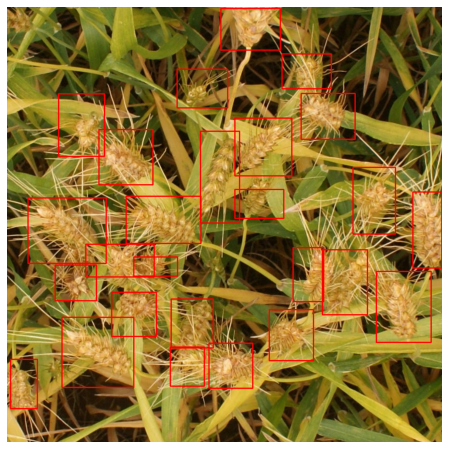

time: 478 ms


In [31]:
show_img(num,true_boxes)
#show_img(num,pred_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


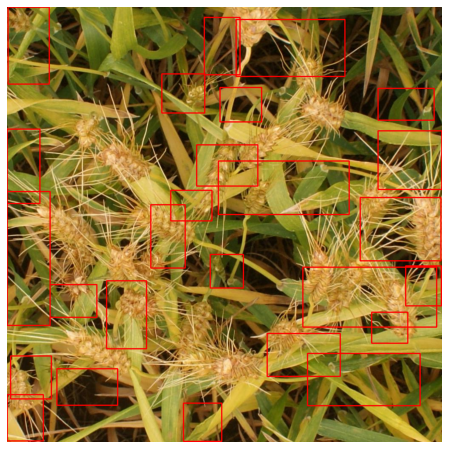

time: 503 ms


In [32]:
pred_boxes_conf = pred_boxes[confidences > 0.5]
show_img(num,pred_boxes_conf)
#show_img(num,pred_boxes)

In [33]:
pred_boxes_conf

tensor([[8.3103e+02, 4.4868e+02, 1.0219e+03, 5.9786e+02],
        [4.2689e-01, 4.3455e+02, 1.0162e+02, 7.4959e+02],
        [8.7394e+02, 2.9102e+02, 1.0238e+03, 4.2939e+02],
        [2.3425e+02, 6.4430e+02, 3.2876e+02, 8.0400e+02],
        [0.0000e+00, 9.1244e+02, 8.5926e+01, 1.0216e+03],
        [5.3949e+02, 2.9103e+01, 7.9525e+02, 1.6326e+02],
        [4.4651e+02, 3.2483e+02, 5.9010e+02, 4.2149e+02],
        [4.1599e+02, 9.3222e+02, 5.0525e+02, 1.0223e+03],
        [3.6420e+02, 1.5771e+02, 4.6525e+02, 2.4935e+02],
        [8.1997e+00, 8.2183e+02, 1.0461e+02, 9.2241e+02],
        [4.9772e+02, 3.6231e+02, 8.0600e+02, 4.8895e+02],
        [4.6452e+02, 2.4317e+01, 5.4812e+02, 1.5978e+02],
        [6.1208e+02, 7.6824e+02, 7.8484e+02, 8.6970e+02],
        [4.7893e+02, 5.8227e+02, 5.5639e+02, 6.6183e+02],
        [7.0724e+02, 8.1539e+02, 9.7211e+02, 9.3878e+02],
        [3.3812e+02, 4.6552e+02, 4.1999e+02, 6.1428e+02],
        [1.1790e+02, 8.5106e+02, 2.6064e+02, 9.3772e+02],
        [8.736

time: 8.4 ms


In [34]:
#boxes_pred = pred_boxes[confidences > threshold]
#confidences = confidences[confidences > threshold]

confidences = confidences.cpu()
pred_boxes = pred_boxes.cpu()
confidences = list(confidences)

time: 1.41 ms


In [35]:
#print('pred_boxes->',pred_boxes.shape)
#print('true_boxes->',true_boxes)
#print('confidences->',confidences)

time: 339 µs


In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
# Load the trained weights
model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
model.eval()#x = model.to(device)

detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    #print('images->',images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

cuda
time: 806 ms


In [37]:
true_boxes

tensor([[ 121.,  204.,  229.,  351.],
        [ 216.,  288.,  343.,  418.],
        [  49.,  449.,  233.,  603.],
        [ 280.,  445.,  456.,  556.],
        [ 455.,  292.,  547.,  508.],
        [ 536.,  261.,  670.,  397.],
        [ 536.,  429.,  651.,  497.],
        [ 692.,  203.,  819.,  311.],
        [ 647.,  110.,  763.,  192.],
        [ 503.,    3.,  643.,  101.],
        [ 400.,  146.,  519.,  237.],
        [ 814.,  377.,  914.,  534.],
        [ 955.,  435., 1023.,  614.],
        [ 869.,  622.,  998.,  789.],
        [ 742.,  571.,  848.,  724.],
        [ 673.,  566.,  745.,  693.],
        [ 617.,  712.,  721.,  832.],
        [ 475.,  791.,  578.,  897.],
        [ 384.,  800.,  464.,  892.],
        [ 386.,  687.,  485.,  802.],
        [ 246.,  671.,  351.,  775.],
        [ 298.,  588.,  401.,  633.],
        [ 185.,  558.,  346.,  635.],
        [ 113.,  607.,  210.,  691.],
        [ 129.,  730.,  298.,  895.],
        [   8.,  829.,   71.,  945.]], dtype=torch

time: 5.15 ms


In [38]:
pred_boxes

tensor([[8.3103e+02, 4.4868e+02, 1.0219e+03, 5.9786e+02],
        [4.2689e-01, 4.3455e+02, 1.0162e+02, 7.4959e+02],
        [8.7394e+02, 2.9102e+02, 1.0238e+03, 4.2939e+02],
        [2.3425e+02, 6.4430e+02, 3.2876e+02, 8.0400e+02],
        [0.0000e+00, 9.1244e+02, 8.5926e+01, 1.0216e+03],
        [5.3949e+02, 2.9103e+01, 7.9525e+02, 1.6326e+02],
        [4.4651e+02, 3.2483e+02, 5.9010e+02, 4.2149e+02],
        [4.1599e+02, 9.3222e+02, 5.0525e+02, 1.0223e+03],
        [3.6420e+02, 1.5771e+02, 4.6525e+02, 2.4935e+02],
        [8.1997e+00, 8.2183e+02, 1.0461e+02, 9.2241e+02],
        [4.9772e+02, 3.6231e+02, 8.0600e+02, 4.8895e+02],
        [4.6452e+02, 2.4317e+01, 5.4812e+02, 1.5978e+02],
        [6.1208e+02, 7.6824e+02, 7.8484e+02, 8.6970e+02],
        [4.7893e+02, 5.8227e+02, 5.5639e+02, 6.6183e+02],
        [7.0724e+02, 8.1539e+02, 9.7211e+02, 9.3878e+02],
        [3.3812e+02, 4.6552e+02, 4.1999e+02, 6.1428e+02],
        [1.1790e+02, 8.5106e+02, 2.6064e+02, 9.3772e+02],
        [8.736

time: 4.8 ms


In [46]:
results

[{'image_id': 'f5a1f0358.jpg',
  'PredictionString': '0.9915 140 750 161 123 0.9899 543 271 110 113 0.9891 887 639 87 145 0.9875 280 458 169 103 0.9875 686 204 116 91 0.9872 550 403 78 98 0.9864 940 428 83 190 0.9857 151 249 79 87 0.9853 441 297 115 188 0.9843 0 843 70 112 0.9821 603 728 101 88 0.9810 815 410 98 92 0.9801 693 564 83 134 0.9779 64 459 143 127 0.9757 220 312 120 102 0.9753 665 108 84 96 0.9660 409 174 70 68 0.9490 394 684 96 150 0.9454 253 671 109 74 0.9285 442 801 163 97 0.9280 231 561 83 102 0.8991 753 585 102 132 0.8903 1 2 66 64 0.8676 525 1 109 102 0.7490 292 578 83 94 0.6749 92 823 55 58 0.5994 248 564 109 112'},
 {'image_id': 'cc3532ff6.jpg',
  'PredictionString': '0.9959 769 827 169 164 0.9950 72 804 140 172 0.9944 487 575 102 137 0.9929 95 608 84 143 0.9916 375 0 84 99 0.9911 262 643 101 167 0.9906 554 835 129 169 0.9905 611 431 85 98 0.9903 473 403 123 152 0.9896 916 124 106 94 0.9885 691 473 143 86 0.9829 1 406 152 114 0.9790 560 305 110 107 0.9718 780 38 91 9

time: 3.36 ms


In [40]:
#score = calculate_mean_precision(boxes_true=true_boxes, boxes_pred=pred_boxes, confidences=confidences)
score = mean_average_precision()
score

0.6332466350936112

time: 2.83 s


In [47]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,f5a1f0358.jpg,0.9915 140 750 161 123 0.9899 543 271 110 113 ...
1,cc3532ff6.jpg,0.9959 769 827 169 164 0.9950 72 804 140 172 0...
2,cb8d261a3.jpg,0.9880 753 711 84 84 0.9878 22 861 78 148 0.98...
3,aac893a91.jpg,0.9929 558 534 121 184 0.9904 618 917 75 103 0...
4,796707dd7.jpg,0.9879 897 333 107 89 0.9806 504 787 92 93 0.9...


time: 8.93 ms


In [49]:
DIR_INPUT

'/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'

time: 1.82 ms


In [50]:
test_df.to_csv(DIR_INPUT + '/submission.csv', index=False)

time: 28.4 ms


# Test precision

In [41]:
def test_calc_precision():
    boxes_true = torch.tensor([
        [0., 0., 10., 10.],     # GT1
        [0., 0., 12., 10.]      # GT2
    ])
    boxes_pred = torch.tensor([
        [0., 0., 0., 0.],      # P1
        [0., 0., 0., 0.],       # P2
        [0., 0., 10., 10.]
    ])
    confidences = [.5, .9]
    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences, threshold=.5)
    #assert score == 1.

    confidences = [.9, .5]
    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences, threshold=.5)
    #assert score == 1/3

    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred,
                                confidences=confidences, threshold=.5)
    print('test_calc_precision->',score)
    #assert score == 0

time: 2.68 ms


In [42]:
test_calc_precision()

test_calc_precision-> 0.25
time: 2.42 ms


# MAP

In [43]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

time: 5.27 ms


In [44]:
boxes

array([[ 458,  495,  538,  631],
       [ 464,  353,  586,  448],
       [ 107,  587,  247,  668],
       [ 941,  649, 1021,  747],
       [ 391,  795,  468,  883],
       [   0,  912,  106,  990],
       [ 732,  890,  828,  977],
       [   0,    0,  105,   75],
       [ 534,  871,  639,  988],
       [ 123,  842,  204,  913],
       [ 909,  882,  979,  979],
       [ 229,    0,  323,   58],
       [ 426,   65,  533,  141],
       [ 732,  154,  814,  243],
       [  96,    0,  221,   56],
       [ 475,   11,  549,   85],
       [   0,  737,   86,  844],
       [ 928,  773, 1017,  857],
       [ 786,  728,  885,  803],
       [ 448,  970,  550, 1022],
       [ 111,   38,  213,  109],
       [ 988,  583, 1024,  671],
       [ 889,   52,  992,  142],
       [ 434,  481,  496,  553],
       [ 241, 1001,  291, 1024]], dtype=int32)

time: 2.83 ms


In [45]:
            #score = mean_average_precision(input_size=1024)


time: 283 µs
